In [50]:
import numpy as np
import os
from PIL import Image
import pathlib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import seaborn as sns

## Defining the path for train and test images

In [44]:
data_dir_train = pathlib.Path("C:/Users/Anand Mall/Downloads/My/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("C:/Users/Anand Mall/Downloads/My/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

## Define image size and class names

In [52]:
IMG_SIZE = (180, 180)
class_names = [d.name for d in data_dir_train.iterdir() if d.is_dir()]
n_classes = len(class_names)

In [55]:
## Function to load and preprocess images

In [56]:
def load_and_preprocess_images(data_dir, class_names, subset_fraction=1.0):
    images = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = data_dir / class_name
        img_paths = [p for p in class_dir.glob('*.jpg')]
        subset_size = int(len(img_paths) * subset_fraction)
        selected_paths = img_paths[:subset_size]
        
        for img_path in selected_paths:
            img = Image.open(img_path).resize(IMG_SIZE)
            img_array = np.array(img) / 255.0  
            images.append(img_array.flatten()) 
            labels.append(class_idx)
    
    return np.array(images), np.array(labels)

## Load training data

In [47]:
X_train_full, y_train_full = load_and_preprocess_images(data_dir_train, class_names)
print(f"Training data shape: {X_train_full.shape}, Labels shape: {y_train_full.shape}")

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)



Loading and preprocessing training data...
Training data shape: (2239, 97200), Labels shape: (2239,)


## Train the SVM model

In [48]:
svm_model = SVC(kernel='poly',
                degree=2,
                C=2.0,           
                gamma='scale',     
                probability=True)
svm_model.fit(X_train, y_train)

Training SVM model...


SVC(C=2.0, degree=2, kernel='poly', probability=True)

In [57]:
## Load and preprocess test data

In [49]:

X_test, y_test = load_and_preprocess_images(data_dir_test, class_names, subset_fraction=1.0)


 Accuracy: 0.6087


## Evaluate on the test

In [ ]:
y_pred_test = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f' Accuracy: {test_accuracy:.4f}')

## Classification Report


Classification Report (Test Set):
                            precision    recall  f1-score   support

         actinic keratosis       0.78      0.58      0.67        12
      basal cell carcinoma       0.75      0.64      0.69        14
            dermatofibroma       0.75      0.82      0.78        11
                  melanoma       0.31      0.64      0.42        14
                     nevus       0.40      0.31      0.35        13
pigmented benign keratosis       0.60      0.75      0.67        16
      seborrheic keratosis       0.00      0.00      0.00        10
   squamous cell carcinoma       0.80      0.67      0.73        12
           vascular lesion       0.92      0.92      0.92        13

                  accuracy                           0.61       115
                 macro avg       0.59      0.59      0.58       115
              weighted avg       0.60      0.61      0.59       115



D:\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


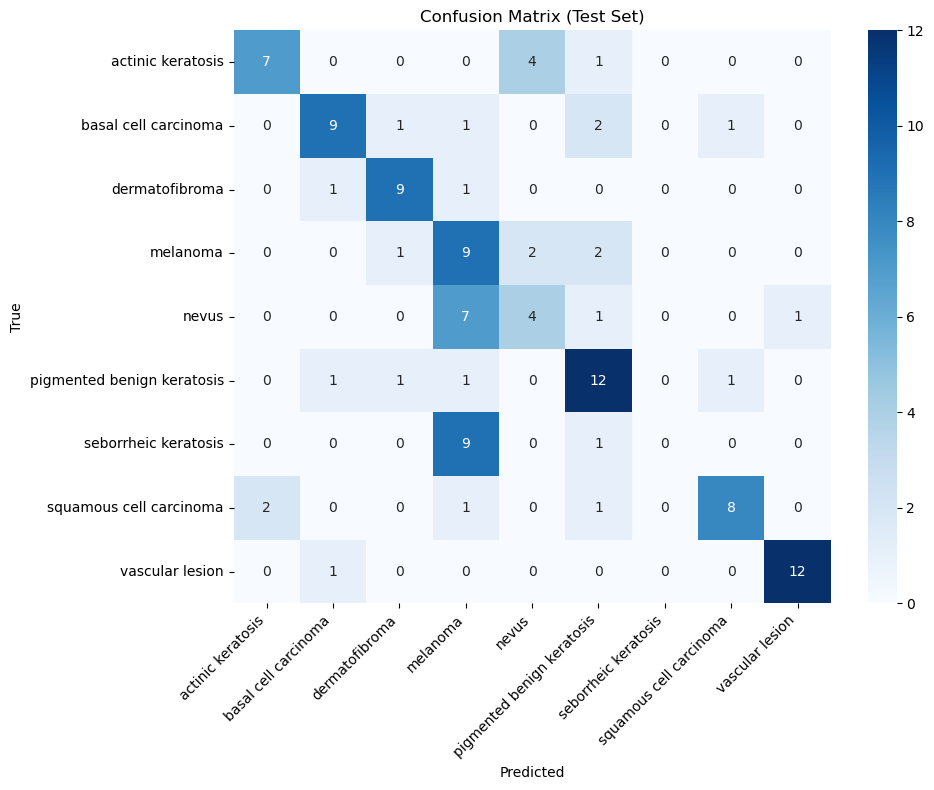

In [53]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=class_names))

## Confusion Matrix


In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##  ROC and AUC Curves

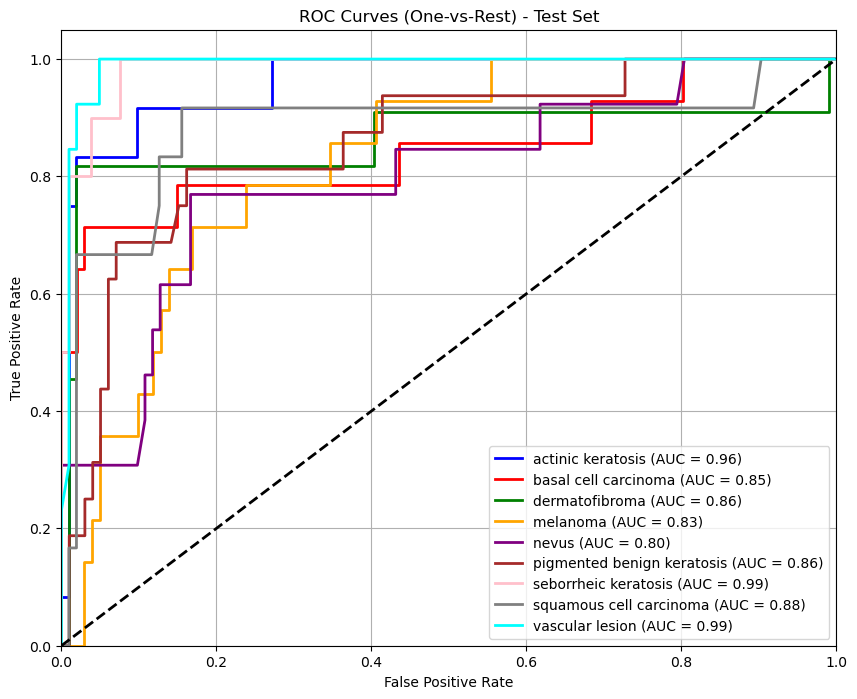


AUC Scores (Test Set):
actinic keratosis: 0.96
basal cell carcinoma: 0.85
dermatofibroma: 0.86
melanoma: 0.83
nevus: 0.80
pigmented benign keratosis: 0.86
seborrheic keratosis: 0.99
squamous cell carcinoma: 0.88
vascular lesion: 0.99


In [54]:
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_score = svm_model.predict_proba(X_test)  

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest) - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC scores
print("\nAUC Scores (Test Set):")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")

## Save the Model

In [ ]:
import pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)